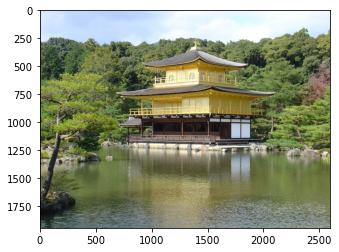

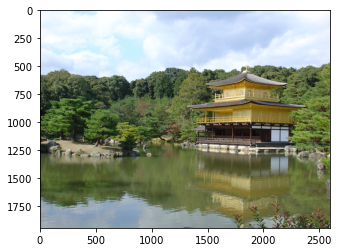

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pygcransac
from time import time

img1 = cv2.cvtColor(cv2.imread('../build/data/Kyoto/Kyoto1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/Kyoto/Kyoto2.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [21]:
#We will detect ORB features and match them with cross-check test
det = cv2.ORB_create(1000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

tentatives = bf.match(descs1,descs2)

In [22]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [23]:
img1.shape

(1944, 2592, 3)

140.0 inliers found
0.022938013076782227 sec cv2
176.0 inliers found
0.013962984085083008 sec gc-ransac


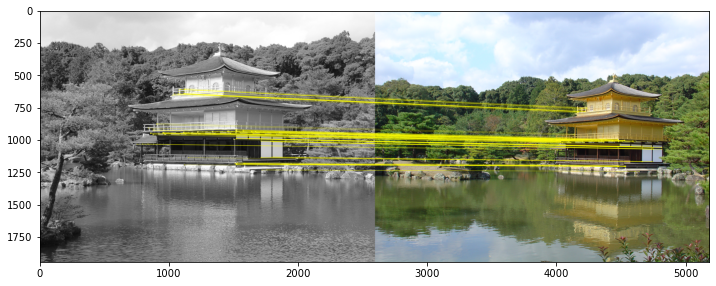

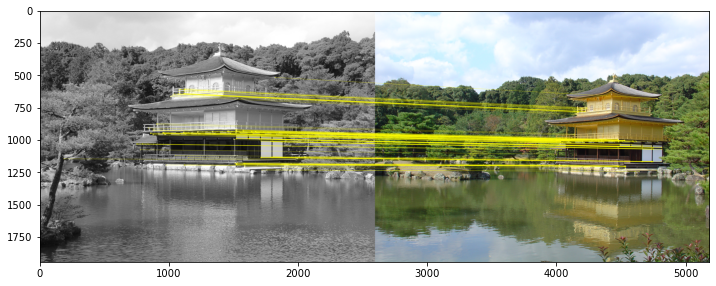

In [33]:
def verify_cv2_fundam(kps1, kps2, tentatives):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,1,2)
    H, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, 3.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

def verify_pygcransac_fundam(kps1, kps2, tentatives, h1, w1, h2, w2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = pygcransac.findFundamentalMatrix(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        h1, w1, h2, w2, 3.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

t=time()
cv2_H, cv2_mask = verify_cv2_fundam(kps1,kps2,tentatives)
print (time()-t, 'sec cv2')
t=time()
mag_H, mag_mask = verify_pygcransac_fundam(kps1,kps2,tentatives, img1.shape[0],img1.shape[1],
                                   img2.shape[0], img2.shape[1])
print (time()-t, 'sec gc-ransac')

draw_matches(kps1, kps2, tentatives, img1, img2, cv2_mask )
draw_matches(kps1, kps2, tentatives, img1, img2, mag_mask)